In [25]:
# Installs
!pip install pyyaml==5.1
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q datasets
!pip install -q pytesseract

  Using cached PyYAML-5.1-cp311-cp311-win_amd64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1


ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\lukask\\AppData\\Local\\anaconda3\\Lib\\site-packages\\~~ml\\_yaml.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [26]:
import json
from PIL import Image, ImageDraw, ImageFont

# Paths
annotation_file_path = 'C:/Users/lukask/Coding/Interface Projects/Detection/LayoutLM/finetune_on_documents_try_3/data/output_data.txt'
image_directory = 'C:/Users/lukask/Coding/Interface Projects/Detection/Complete_Data/fichtner_dataset_v2/png_with_label_downscaled_merge'

def load_image_with_annotations(image_path, annotations):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = None  # Use PIL's default font if specific font loading fails

    for token, bbox, tag in zip(annotations['tokens'], annotations['bboxes'], annotations['ner_tags']):
        draw.rectangle([(bbox[0], bbox[1]), (bbox[2], bbox[3])], outline='red', width=2)
        text_position = (bbox[0], bbox[1] - 10)
        text = f'{tag}: {token}'
        text = text.encode('utf-8', 'ignore').decode('utf-8')
        draw.text(text_position, text, fill='blue', font=font)

    image.show()

def visualize_annotation_for_specific_file(file_path, image_dir, specific_file_name):
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                annotation = json.loads(line.strip())
                if annotation['file_name'] == specific_file_name:
                    image_path = f"{image_dir}/{annotation['file_name']}"
                    load_image_with_annotations(image_path, annotation)
                    break
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
            except FileNotFoundError:
                print(f"Image file not found: {image_path}")
            except Exception as e:
                print(f"An error occurred: {e}")

# Example usage
specific_file_name = "000-1450-00000-23-GP-025-00002-00_Lageplan 1450_2_Mast_1018_-_Mast_1023.png"  # Replace this with your specific image file name
visualize_annotation_for_specific_file(annotation_file_path, image_directory, specific_file_name)


# Downloading real model and data:

# Inference:

In [27]:
from transformers import AutoModelForTokenClassification
from transformers import LayoutLMv3Processor

processor = LayoutLMv3Processor.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")

In [28]:
# from huggingface_hub import notebook_login
# notebook_login()

In [29]:
from datasets import load_dataset

# this dataset uses the new Image feature :)
dataset = load_dataset("Resi/layoutlmv3-full-annotation-filtered")

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 439
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 24
    })
})

In [31]:
example = dataset["test"][17]
print(example.keys())
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

# Calculate the start index to get the last 512 tokens
start_index = max(0, len(words) - 512)

# Truncate data to get the last 512 tokens, boxes, and labels
truncated_words = words[start_index:]
truncated_boxes = boxes[start_index:]
truncated_word_labels = word_labels[start_index:]

# Process the truncated data
encoding = processor(image, truncated_words, boxes=truncated_boxes, word_labels=truncated_word_labels, return_tensors="pt", truncation=True, max_length=512)
for k, v in encoding.items():
    print(f'{k}: {v.shape}')


dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'])
input_ids: torch.Size([1, 441])
attention_mask: torch.Size([1, 441])
bbox: torch.Size([1, 441, 4])
labels: torch.Size([1, 441])
pixel_values: torch.Size([1, 3, 224, 224])


In [32]:
import torch
with torch.no_grad():
  outputs = model(**encoding)
logits = outputs.logits
logits.shape

torch.Size([1, 441, 6])

In [33]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)
labels = encoding.labels.squeeze().tolist()
print(labels)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 3, 3, 3, 5, 3, 5, 5, 5, 3, 3, 5, 2, 2, 2, 5, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [34]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

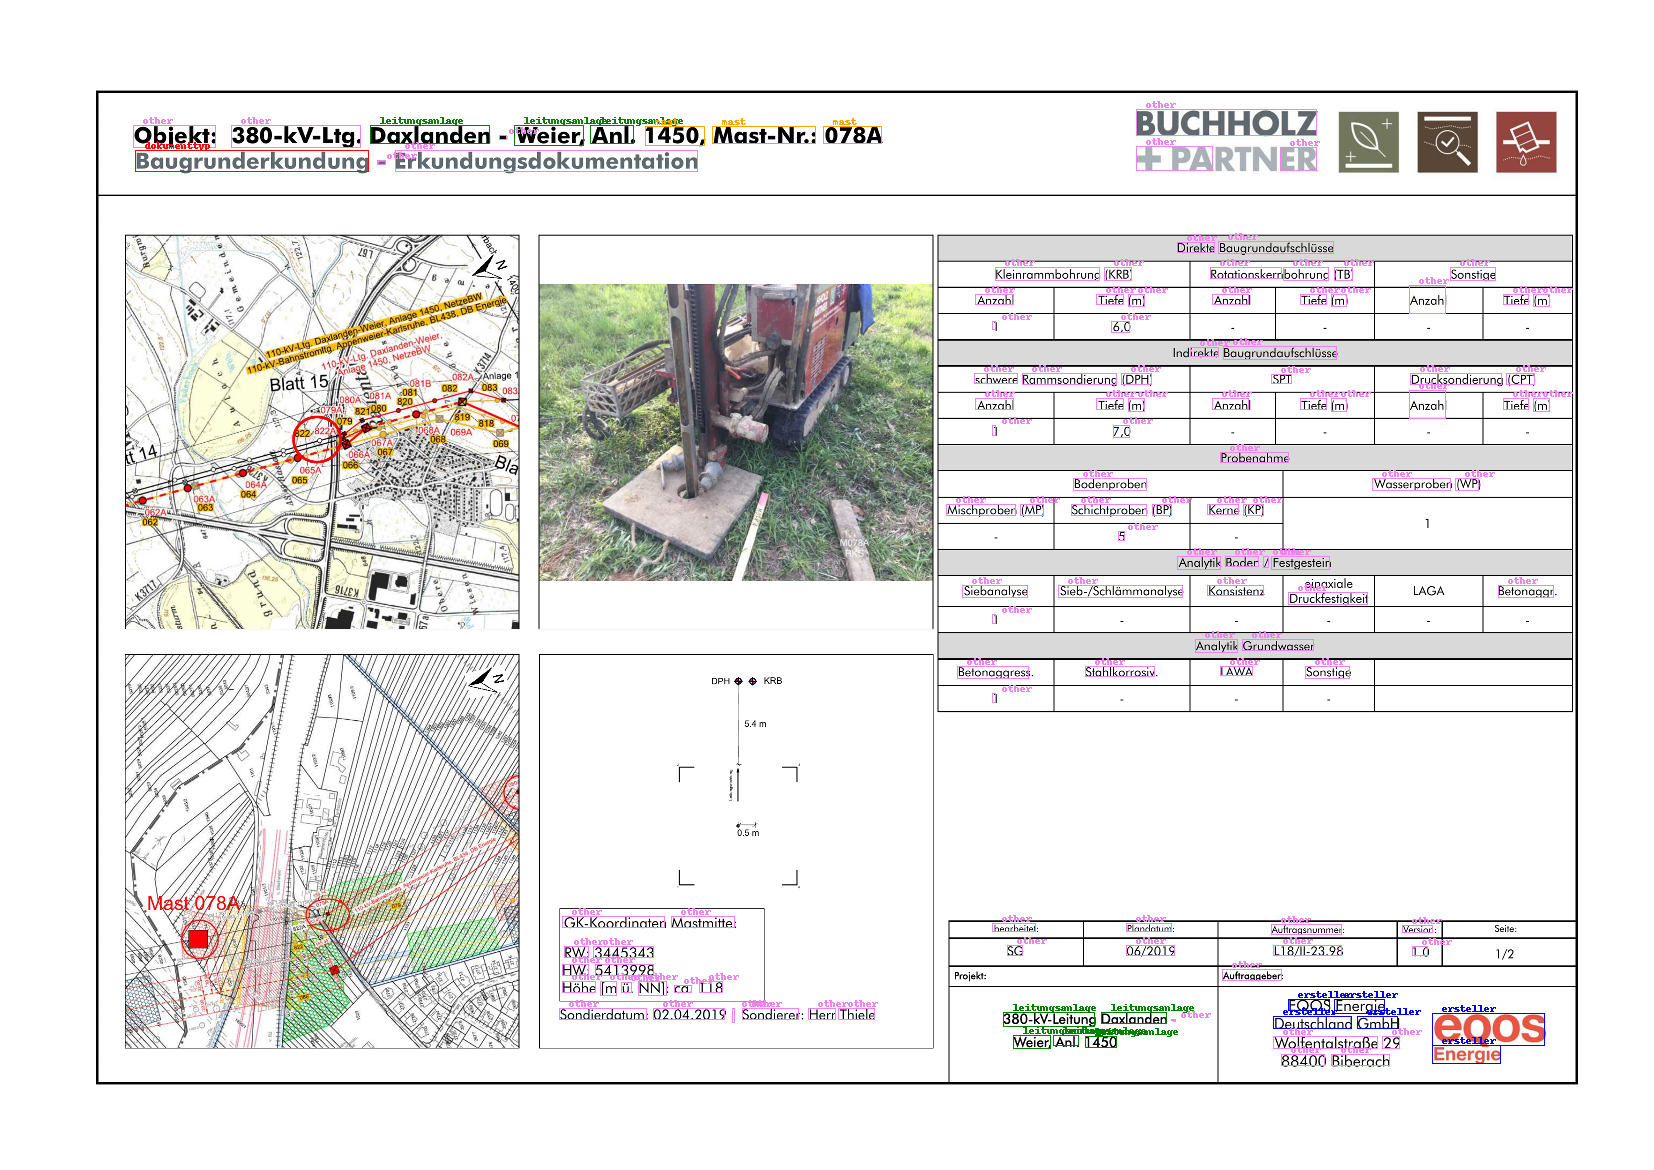

In [35]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'ersteller':'blue', 'leitungsanlage':'green', 'mast':'orange', 'dokumenttyp':'red', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

# Ground truth:

In [36]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

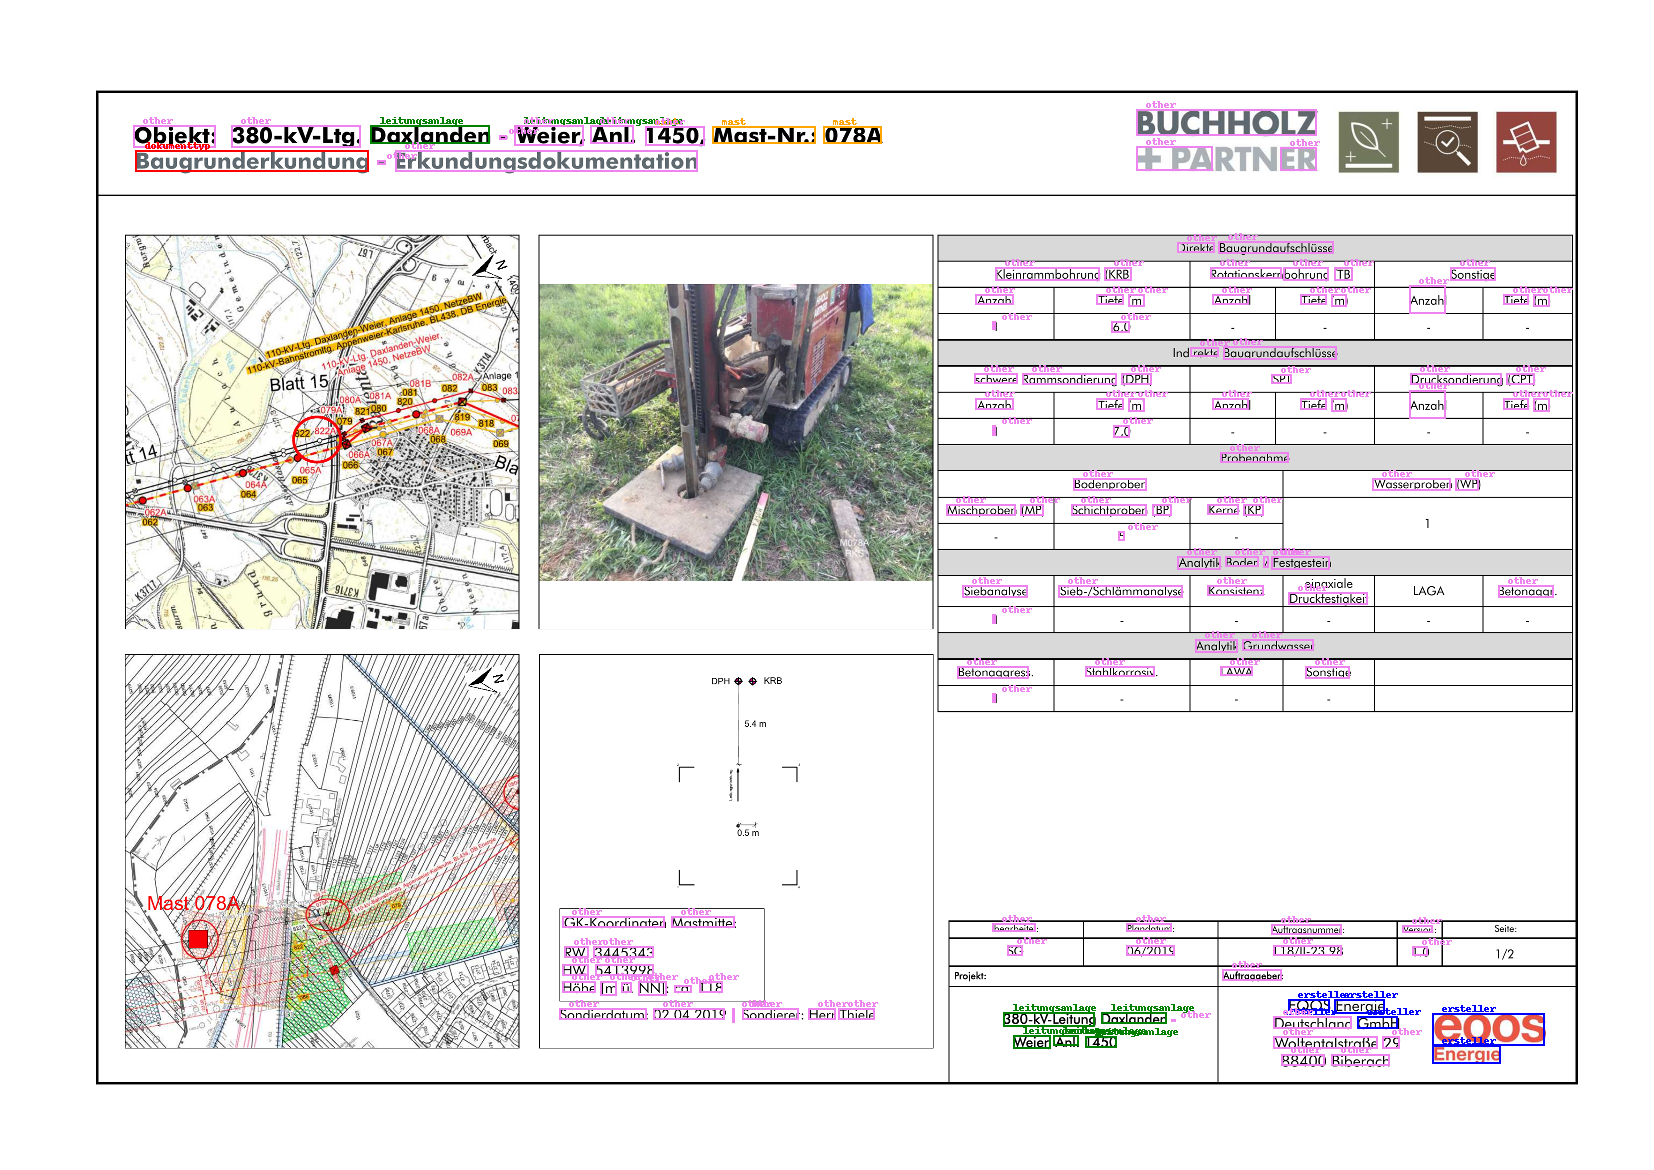

In [37]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

# True Inference

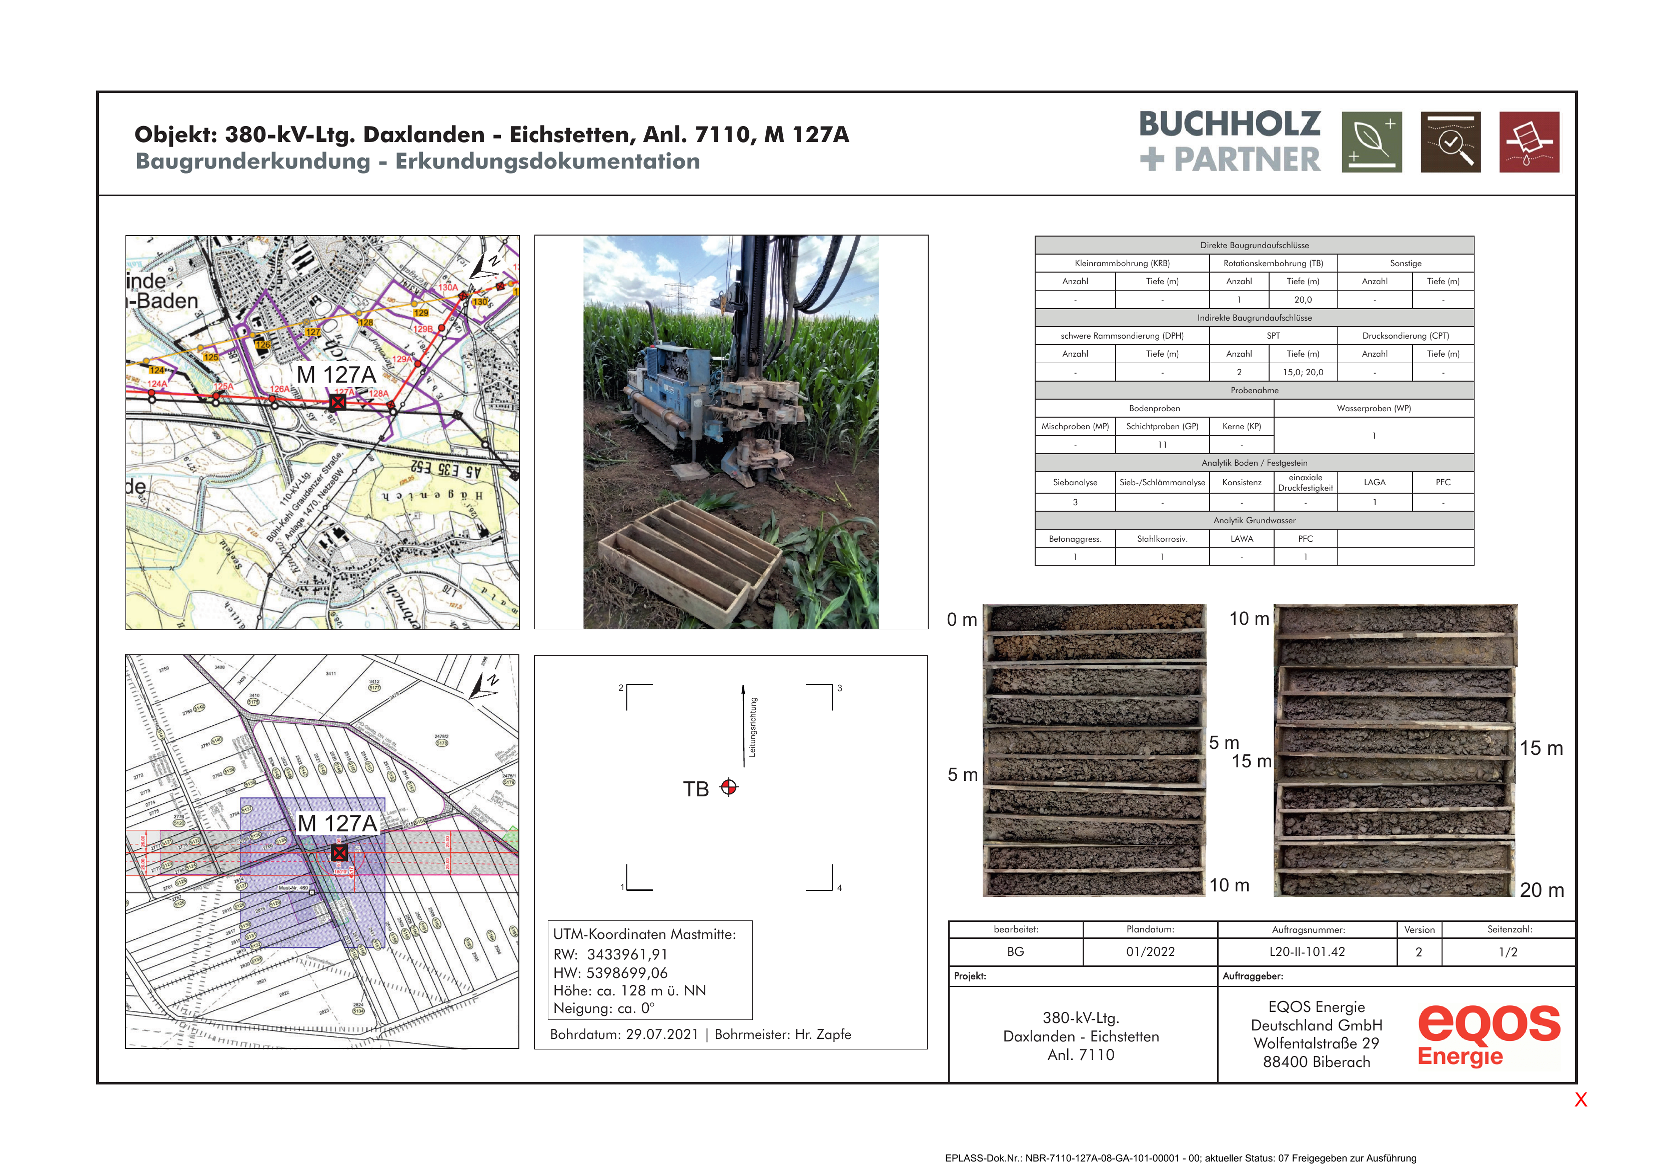

In [38]:
from datasets import load_dataset
# image_path = r"C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_merge\DP_7110_009A.png"
# image = Image.open(image_path)
# image
#example = dataset["test"][23]  # Using one example for demonstration
#image = example["image"]
image = Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\319.png")
# dataset = load_dataset("Resi/layoutlmv3-full-annotation-filtered")
# image = dataset['train'][13]['image']
#image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\segm_extract\cropped_segment_1.png")
image

In [39]:
label2id

{'B-Ersteller': 0,
 'B-Leitungsanlage': 1,
 'B-Dokumenttyp': 2,
 'B-Mast': 3,
 'B-Massstab': 4,
 'O': 5}

In [40]:
from transformers import LayoutLMv2Processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
#processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])


In [41]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [42]:
from transformers import LayoutLMv3ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv3ForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)

# forward pass
outputs = model(**encoding)
print(outputs.logits.shape)

torch.Size([1, 235, 6])


In [43]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

In [44]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [45]:
print(true_predictions)
print(true_boxes)

['O', 'O', 'O', 'B-Leitungsanlage', 'O', 'B-Leitungsanlage', 'B-Leitungsanlage', 'O', 'B-Mast', 'B-Mast', 'O', 'B-Dokumenttyp', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Ersteller', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Leitungsanlage', 'O', 'B-Leitungsanlage', 'O', 'O', 'O', 'B-Leitungsanlage', 'B-Leitungsanlage', 'O', 'O', 'B-Ersteller', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[0.0, 0.0, 0.0, 0.0], [133.97400000000002, 124.02, 215.02, 146.25], [224.94400000000002, 124.02, 353.956, 146.25], [363.88, 124.02, 482.96799999999996, 142.74], [492.892, 134.55, 499.508, 136.89000000000001], [509.432, 124.02, 635.136, 143.91], [641.7520000000001, 124.02, 684.756, 142.74], [694.68, 125.19, 755.878, 143.91], [774.072, 125.19, 783.996, 141.57], [793.92, 125.19, 848.5020000000001, 141.57], [1139.606, 109.98, 1319.892, 135.72], [135.62800000000001, 150.93, 368.842, 171.9899

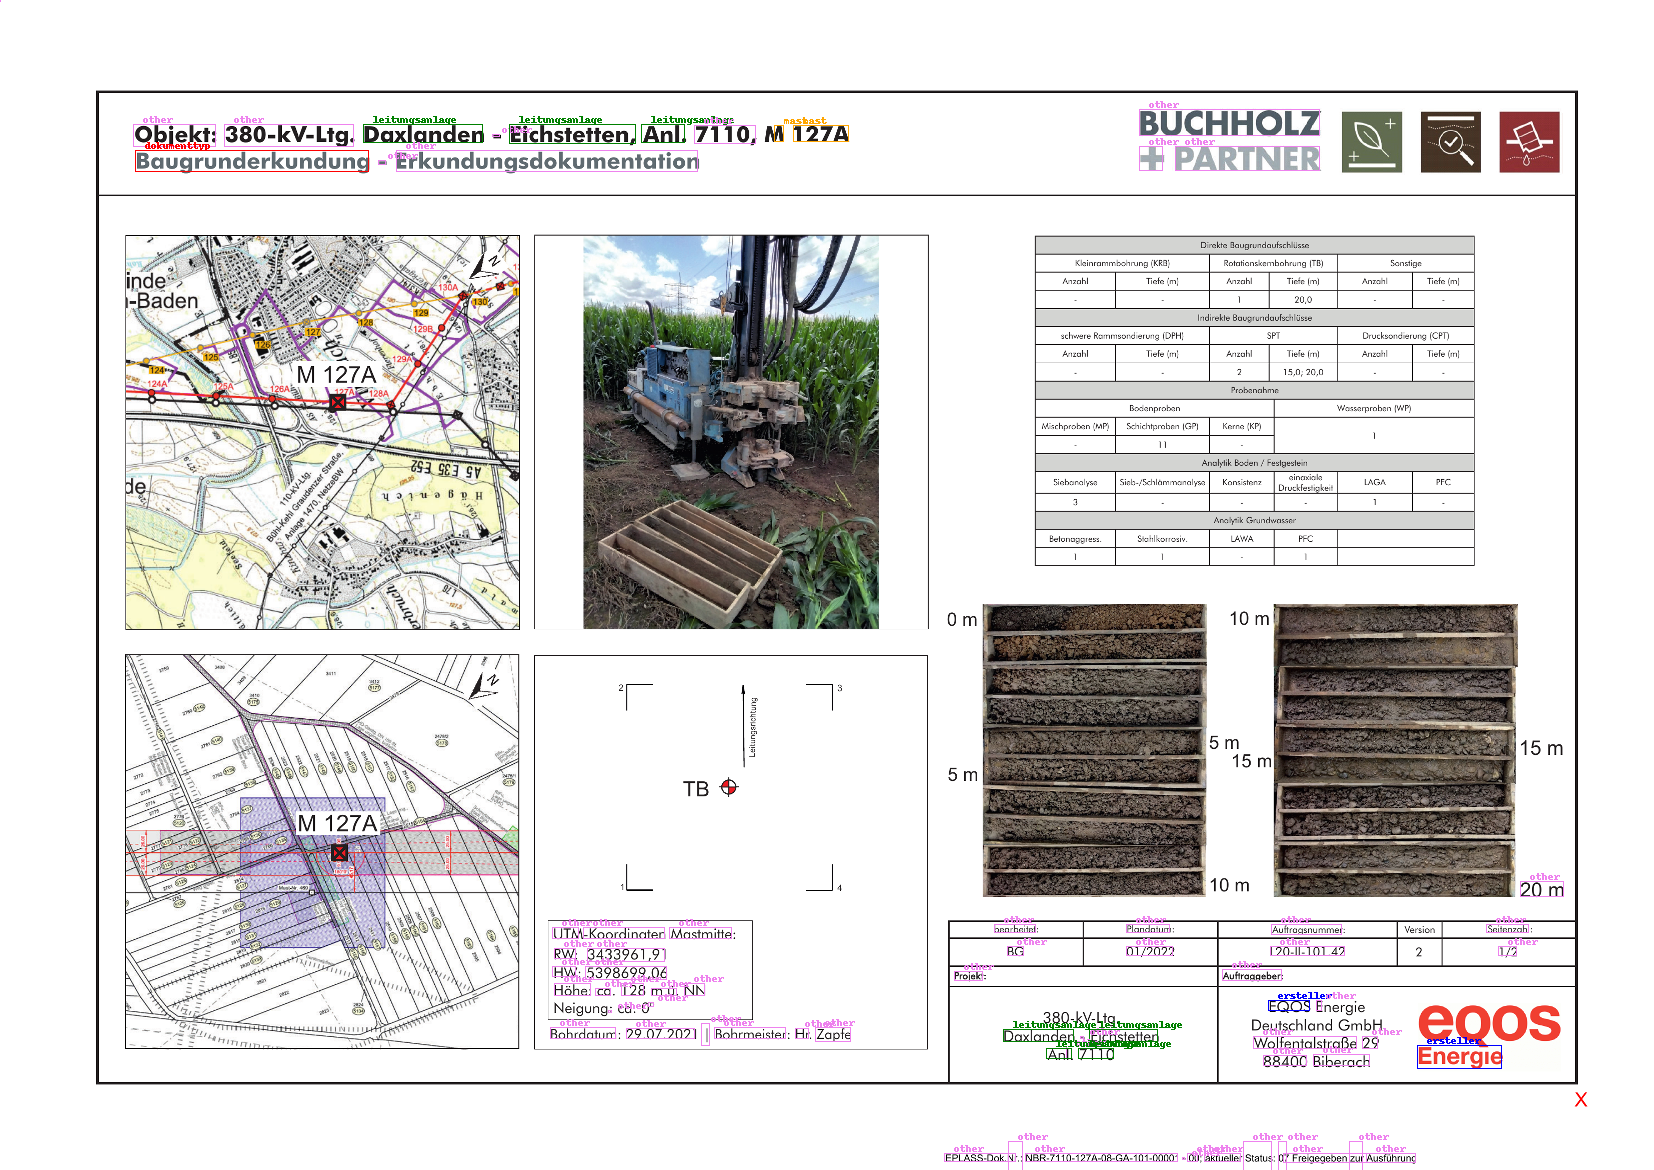

In [46]:
from PIL import Image, ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'ersteller':'blue', 'leitungsanlage':'green', 'mast':'orange', 'dokumenttyp':'red', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

# Calculate accuracy:

In [47]:
from PIL import Image, ImageDraw

def visualize_boxes_image(image, true_boxes, pred_boxes, true_labels, pred_labels):
    image_with_boxes = image.copy()
#     try:
#         image_with_boxes.save("image_with_boxes.png")
#         print("Image saved successfully!")
#     except Exception as e:
#         print("Error while saving image:", e)
#         return  # Exit the function if there's an error while saving the image

    draw = ImageDraw.Draw(image_with_boxes)

    # Draw ground truth boxes in blue
    for box, label in zip(true_boxes, true_labels):
        draw.rectangle(box, outline='blue', width=3)  # Increase thickness of blue boxes
        draw.text((box[0], box[1]-20), label, fill='blue', font=ImageFont.truetype("arial.ttf", 6))  # Add text label to blue boxes

    # Draw predicted boxes in red
    for box, label in zip(pred_boxes, pred_labels):
        draw.rectangle(box, outline='red')
        draw.text((box[0], box[1]-25), label, fill='red', font=ImageFont.truetype("arial.ttf", 6))  # Add text label to red boxes

    image_with_boxes.show()  # Display the image with bounding boxes



In [ ]:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
from collections import defaultdict
import matplotlib.pyplot as plt

# Initialize model and processor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)

# Define IoU function
def bbox_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Initialize counters
label_correct = defaultdict(int)
label_incorrect = defaultdict(int)
true = 0
false = 0
iou_threshold = 0.9

# Loop over dataset["test"]
for example in dataset["train"]:

    # Process example
    image = example["image"]
    encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    
    if encoding.input_ids.size(1) > 512:
        continue

    for k, v in encoding.items():
        encoding[k] = v.to(device)

    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    width, height = image.size
    pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
    pred_labels = [id2label[pred] for pred in predictions]

    ground_truth_boxes = [unnormalize_box(box, width, height) for box in example['bboxes']]
    ground_truth_labels = [id2label[label] for label in example['ner_tags']]

    for pbox, plabel in zip(pred_boxes, pred_labels):
        was_detected = False
        potential_false_positive = True

        for gt_box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
            iou = bbox_iou(pbox, gt_box)
            if iou > iou_threshold:
                if plabel == "O" and gt_label == "O":
                    continue
                elif plabel == gt_label:
                    was_detected = True
                    potential_false_positive = False
                    true += 1
                    label_correct[plabel] += 1
                    break
                else:
                    potential_false_positive = True
                    break

        if not was_detected:
            if potential_false_positive and plabel != "O":
                false += 1
                label_incorrect[plabel] += 1

# Plotting the results
labels = list(label_correct.keys())
correct_counts = [label_correct[label] for label in labels]
incorrect_counts = [label_incorrect[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, correct_counts, label='Correct', color='b', alpha=0.7)
plt.bar(labels, incorrect_counts, bottom=correct_counts, label='Incorrect', color='r', alpha=0.7)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Correct and Incorrect Predictions per Label')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (120732948 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1500 > 512). Running this sequence through the model will result in indexing errors
C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3176: Decompre

In [ ]:
true, false

In [ ]:
true/(true+false)

In [ ]:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def bbox_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)

iou_threshold = 0.99
results = []

example = dataset["test"][17]  # Using one example for demonstration
image = example["image"]
image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\test_segment.png")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')

for k, v in encoding.items():
    encoding[k] = v.to(device)

outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size
pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
pred_labels = [id2label[pred] for pred in predictions]

ground_truth_boxes = [unnormalize_box(box, width, height) for box in example['bboxes']]
ground_truth_labels = [id2label[label] for label in example['ner_tags']]

# Tracking for precision and recall
detected_labels = set()
all_predicted_labels = {plabel for plabel in pred_labels if plabel != "O"}
all_true_labels = {gt_label for gt_label in ground_truth_labels if gt_label != "O"}
true = 0
false = 0
# Match detection
for pbox, plabel in zip(pred_boxes, pred_labels):
    was_detected = False
    for gt_box, gt_label in zip(ground_truth_boxes, ground_truth_labels):
        iou = bbox_iou(pbox, gt_box)
        if iou > iou_threshold:
            if plabel == "O" and gt_label == "O":
                # Ignore completely if both are 'O'
                continue
            elif plabel == gt_label:
                # Correct match found
                was_detected = True
                true += 1
                detected_labels.add(plabel)
                print(f"Matched: plabel: {plabel}, gt_label: {gt_label}")
                results.append({"prediction": plabel, "matched": was_detected})
                continue
            else:
                # One is 'O' and the other is not, or they are just different
                #print(f"Mismatch: plabel: {plabel}, gt_label: {gt_label}")
                break

    # Count as false positive only if no match was found for this prediction
    if not was_detected and plabel != "O":
        false += 1
        print(f"No true match found for plabel: {plabel}, gt_label: {gt_label}")

    results.append({"prediction": plabel, "matched": was_detected})


precision = len(detected_labels) / len(all_predicted_labels) if all_predicted_labels else 0
recall = len(detected_labels) / len(all_true_labels) if all_true_labels else 0

# Function visualize_boxes_image needs to be defined if not already defined
visualize_boxes_image(image, ground_truth_boxes, pred_boxes, ground_truth_labels, pred_labels)
print(precision)
print(recall)

# Extract the pieces and merge to words:

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [ ]:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import os
import pytesseract

os.environ['KMP_DUPLICATE_LIB_OK']='True'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)

example = dataset["test"][2]  # Using one example for demonstration
image = example["image"]
#image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\test_segment.png")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')

for k, v in encoding.items():
    encoding[k] = v.to(device)

outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size
pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
pred_labels = [id2label[pred] for pred in predictions]

# Filter out only the bounding boxes labeled "mast"
mast_boxes = []
# Filter out only the bounding boxes labeled "mast" and remove duplicates or similar boxes
unique_mast_boxes = []
seen = set()
for box, label in zip(pred_boxes, pred_labels):
    if label == "B-Mast":
        box_tuple = tuple(box)
        if box_tuple not in seen:
            unique_mast_boxes.append(box)
            seen.add(box_tuple)




# Function to crop out the bounding boxes from the image
def crop_boxes_with_margin(image, boxes, margin=4):
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = box
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.width, x2 + margin)
        y2 = min(image.height, y2 + margin)
        cropped_image = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_image)
    return cropped_images

cropped_images = crop_boxes_with_margin(image, unique_mast_boxes)

# Display or save the cropped images
for i, cropped_image in enumerate(cropped_images):
    #cropped_image.show()  # Display the cropped image
    cropped_image.save(f".\data\mast_extract\cropped_mast_{i}.png")  # Save the cropped image with a filename

# Function to extract text from images using OCR
def extract_text_from_image(image):
    return pytesseract.image_to_string(image)

# Extract text from each cropped image
extracted_texts = [extract_text_from_image(cropped_image) for cropped_image in cropped_images]
print(extracted_texts)
# Merge extracted texts into a single sentence
merged_sentence = ' '.join(extracted_texts)
print("Merged Sentence:", merged_sentence)

import re

# Find the index of the first occurrence of "mast" in the merged sentence
first_occurrence_index = merged_sentence.find("mast")

# Get the words after the first occurrence of "mast"
remaining_words = merged_sentence[first_occurrence_index + len("mast"):].strip().split()



# Look to the right for a number

In [ ]:
# import torch
# from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
# import numpy as np
# from PIL import Image
# import os
# import pytesseract

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
# model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
# model.to(device)
# #2#13#17#18#12
# example = dataset["test"][17]
# image = example["image"]
# image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\test_segment.png")
# encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
# offset_mapping = encoding.pop('offset_mapping')

# for k, v in encoding.items():
#     encoding[k] = v.to(device)

# outputs = model(**encoding)
# predictions = outputs.logits.argmax(-1).squeeze().tolist()
# token_boxes = encoding.bbox.squeeze().tolist()

# width, height = image.size
# pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
# pred_labels = [id2label[pred] for pred in predictions]

# # Filter out only the bounding boxes labeled "mast"
# mast_boxes = []
# # Filter out only the bounding boxes labeled "mast" and remove duplicates or similar boxes
# unique_mast_boxes = []
# seen = set()
# for box, label in zip(pred_boxes, pred_labels):
#     if label == "B-Mast":
#         box_tuple = tuple(box)
#         if box_tuple not in seen:
#             unique_mast_boxes.append(box)
#             seen.add(box_tuple)


# # Function to crop out the bounding boxes from the image
# def crop_boxes_with_margin(image, boxes, margin=3):
#     cropped_images = []
#     for box in boxes:
#         x1, y1, x2, y2 = box
#         x1 = max(0, x1 - margin)
#         y1 = max(0, y1 - margin)
#         x2 = min(image.width, x2 + margin)
#         y2 = min(image.height, y2 + margin)
#         cropped_image = image.crop((x1, y1, x2, y2))
#         cropped_images.append(cropped_image)
#     return cropped_images

# cropped_images = crop_boxes_with_margin(image, unique_mast_boxes)

# # Display or save the cropped images
# for i, cropped_image in enumerate(cropped_images):
#     # cropped_image.show()  # Display the cropped image
#     cropped_image.save(f".\data\mast_extract\cropped_mast_{i}.png")  # Save the cropped image with a filename

# # Function to extract text from images using OCR
# def extract_text_from_image(image):
#     return pytesseract.image_to_string(image)

# # Extract text from each cropped image
# # Extract text from each cropped image
# extracted_texts = [extract_text_from_image(cropped_image) for cropped_image in cropped_images]

# # Merge extracted texts into a single sentence
# merged_sentence = ' '.join(extracted_texts)
# print("Merged Sentence:", merged_sentence)

# # Split the merged sentence into words
# words = merged_sentence.split()

# mast_index = None
# mast_bbox = None

# # Find the index of the first occurrence of "Mast" in the merged sentence
# for i, text in enumerate(extracted_texts):
#     if "mast" in text.lower() or "nr" in text.lower():
#         mast_index = i
#         mast_bbox = unique_mast_boxes[i]
#         break

# if mast_index is not None:
#     counter = 0
#     print(mast_index, extracted_texts)
#     ocr_result = None
    
    
#     def adjust_and_ocr(image, x1, y1, x2, y2):
#         y1 -= 2
#         y2 += 2
#         print("Adjusting bounding box to:", (x1, y1, x2, y2))
#         cropped_adjusted_image = image.crop((x1, y1, x2, y2))
#         cropped_adjusted_image.show()
#         return pytesseract.image_to_string(cropped_adjusted_image)

#     # Process cases where there are more texts to the right of "Mast"
#     while counter < 3 and mast_index < len(extracted_texts) - 1 and not any(char.isdigit() for char in extracted_texts[mast_index + 1].strip()):
#         print("Test 1")
#         x1, y1, x2, y2 = mast_bbox
#         x2 += 100  # Horizontally extend the box

#         ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
#         counter+=1
#         if any(char.isdigit() for char in ocr_result):
#             break
#         mast_index += 1
    
#     #Here I have to convert tthe word with Ocr

#     # Process cases where "Mast" is the only text
#     while counter < 3 and len(extracted_texts) == 1 and extracted_texts[mast_index].strip() == "Mast":
#         print("Test 2")
#         x1, y1, x2, y2 = mast_bbox
#         x2 += 100  # Horizontally extend the box

#         ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
#         counter+=1
#         if any(char.isdigit() for char in ocr_result):
#             break
#         # No increment for mast_index here because it's meant to handle a single 'Mast' case
#     if ocr_result:
#         print(f"returned Number would be: {ocr_result.strip()}")
#     else:
#         print(f"returned Number would be: {extracted_texts[mast_index].strip(), extracted_texts[mast_index+1].strip()}")
#         # TODO manchmal list index out of bounds
# else:
#     print("None output")



In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
    
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
    
num_labels = len(label_list)

In [ ]:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
import numpy as np
from PIL import Image
import os
import pytesseract

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)
#2#13#17#18#12
example = dataset["test"][18]
image = example["image"]
#image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\segm_extract\cropped_segment_1.png")
#image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\test_segment.png")
encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')

for k, v in encoding.items():
    encoding[k] = v.to(device)

outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size
pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
pred_labels = [id2label[pred] for pred in predictions]

# Filter out only the bounding boxes labeled "mast"
mast_boxes = []
# Filter out only the bounding boxes labeled "mast" and remove duplicates or similar boxes
unique_mast_boxes = []
seen = set()
for box, label in zip(pred_boxes, pred_labels):
    if label == "B-Mast":
        box_tuple = tuple(box)
        if box_tuple not in seen:
            unique_mast_boxes.append(box)
            seen.add(box_tuple)


# Function to crop out the bounding boxes from the image
def crop_boxes_with_margin(image, boxes, margin=4):
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = box
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.width, x2 + margin)
        y2 = min(image.height, y2 + margin)
        cropped_image = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_image)
    return cropped_images

cropped_images = crop_boxes_with_margin(image, unique_mast_boxes)

# Display or save the cropped images
for i, cropped_image in enumerate(cropped_images):
    # cropped_image.show()  # Display the cropped image
    cropped_image.save(f".\data\mast_extract\cropped_mast_{i}.png")  # Save the cropped image with a filename

# Function to extract text from images using OCR
def extract_text_from_image(image):
    return pytesseract.image_to_string(image)

# Extract text from each cropped image
extracted_texts = [extract_text_from_image(cropped_image) for cropped_image in cropped_images]

# Merge extracted texts into a single sentence
merged_sentence = ' '.join(extracted_texts)
print("Merged Sentence:", merged_sentence)

# Split the merged sentence into words
words = merged_sentence.split()

mast_index = None
mast_bbox = None

# Find the index of the first occurrence of "Mast" in the merged sentence
for i, text in enumerate(extracted_texts):
    if "mast" in text.lower() or "nr" in text.lower():
        mast_index = i
        mast_bbox = unique_mast_boxes[i]
        break

if mast_index is not None:
    counter = 0
    print(mast_index, extracted_texts)
    ocr_result = None
    
    
    def adjust_and_ocr(image, x1, y1, x2, y2):
        y1 -= 2
        y2 += 2
        print("Adjusting bounding box to:", (x1, y1, x2, y2))
        cropped_adjusted_image = image.crop((x1, y1, x2, y2))
        cropped_adjusted_image.show()
        return pytesseract.image_to_string(cropped_adjusted_image)

    # Define a helper function to check if the text contains any keywords followed by a digit
    def has_keyword_followed_by_digit(text, keyword):
        keyword_found = keyword.lower() in text.lower()
        # Checking for digits after the keyword in the whole string
        digits_found = any(char.isdigit() for char in text[text.lower().find(keyword.lower()):])
        return keyword_found and digits_found

    # Redefine loops to handle "Mast" or "Nr."
    while counter < 2:
        current_text = extracted_texts[mast_index].strip()
        if has_keyword_followed_by_digit(current_text, "Mast") or has_keyword_followed_by_digit(current_text, "Nr."):
            break  # If a number is already found right after keyword, no need to adjust

        print("Test 1")
        x1, y1, x2, y2 = mast_bbox
        x2 += 100  # Horizontally extend the box

        ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
        counter += 1
        if any(char.isdigit() for char in ocr_result):
            break  # Break if a number is found after adjustment

        if mast_index < len(extracted_texts) - 1:
            mast_index += 1  # Move to the next text block if no number found and there's more text
        else:
            break  # Exit loop if no more text blocks are available

    # Handle the case where "Mast" or "Nr." is the only text detected (if applicable)
    while counter < 2 and len(extracted_texts) == 1 and (has_keyword_followed_by_digit(extracted_texts[mast_index], "Mast") or has_keyword_followed_by_digit(extracted_texts[mast_index], "Nr.")):
        print("Test 2")
        x1, y1, x2, y2 = mast_bbox
        x2 += 100  # Horizontally extend the box

        ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
        counter += 1
        if any(char.isdigit() for char in ocr_result):
            break  # Break if a number is found
            # No increment for mast_index here because it's meant to handle a single 'Mast' case

    if ocr_result:
        print(f"returned Number would be: {ocr_result.strip()}")
    else:
        def find_mast_followed_by_number(texts):
            mast_found = False  # Flag to indicate whether "Mast" has been found
            for text in texts:
                text = text.lower()  # Convert to lower case to ensure case insensitivity
                if "mast" in text:  # Check if this text is "Mast"
                    mast_found = True
                elif mast_found:
                    if text.isdigit():  # Check if a numeric text is found after "Mast"
                        print(f"Returned Number would be: {text}")
                        return
                    # Optional: You might also check if the text is numeric, even if it's not purely digits
                    # This can handle cases like '22.8', 'No. 228', etc.
                    elif any(char.isdigit() for char in text):
                        print(f"Returned Number (from mixed content) would be: {text}")
                        return
            print("No 'Mast' followed by a number was found.")
        find_mast_followed_by_number([text.strip() for text in extracted_texts])
        # TODO manchmal list index out of bounds
else:
    print("None output")



In [ ]:
image

# Try to split a document in smaller parts and look for mastnr

In [ ]:
#dataset["test"][9]
example = dataset["test"][11]
image = example["image"]

In [ ]:
from typing import List
from PIL import Image

def split_image_horizontally(image: Image, processor, max_tokens: int = 512) -> List[Image]:
    """
    Splits an image horizontally into smaller segments each with fewer than max_tokens tokens.
    
    Parameters:
        image (PIL.Image): The original image to be split.
        processor: The processor used for tokenizing.
        max_tokens (int): The maximum number of tokens for each image segment.
    
    Returns:
        List of Image objects, each representing a segment of the original image.
    """
    width, height = image.size
    segments = []
    current_height = 0

    # Continuously try to split until the entire height is covered
    while current_height < height:
        min_height = 100  # Minimum height increase to attempt finding a valid segment
        found = False
        last_valid_height = current_height + min_height  # Default to minimal segment in case of no valid split found

        for h in range(current_height + min_height, height + min_height, min_height):
            segment = image.crop((0, current_height, width, h))
            encoding = processor(segment, return_offsets_mapping=True, return_tensors="pt")
            num_tokens = encoding.input_ids.size(1)
            print(f"Trying height {h}: {num_tokens} tokens")

            if num_tokens < max_tokens:
                last_valid_height = h
                found = True
            else:
                if found:
                    break  # Use the last valid height
                else:
                    # If even the smallest increment is too large, reduce min_height
                    min_height = max(50, min_height // 2)
                    break

        # Crop using the last valid height that had fewer than max_tokens
        segment = image.crop((0, current_height, width, last_valid_height))
        segments.append(segment)
        current_height = last_valid_height  # Move the current height to the end of the last valid segment

        if not found:
            # Adjust in case no valid segment is found to prevent infinite loop
            current_height += min_height

    return segments

# Example usage:
try:
    image = example["image"]
    segments = split_image_horizontally(image, processor)
    for i, seg_image in enumerate(segments):
        print(f"Segment {i+1}:")
        seg_image.save(f".\data\segm_extract\cropped_segment_{i}.png")
        seg_image.show()
except ValueError as e:
    print(str(e))


In [ ]:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
import numpy as np
from PIL import Image
import os
import pytesseract

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)
#2#13#17#18#12
# example = dataset["test"][18]
# image = example["image"]
image=Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\segm_extract\cropped_segment_2.png")
encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')

for k, v in encoding.items():
    encoding[k] = v.to(device)

outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size
pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
pred_labels = [id2label[pred] for pred in predictions]

# Filter out only the bounding boxes labeled "mast"
mast_boxes = []
# Filter out only the bounding boxes labeled "mast" and remove duplicates or similar boxes
unique_mast_boxes = []
seen = set()
for box, label in zip(pred_boxes, pred_labels):
    if label == "B-Mast":
        box_tuple = tuple(box)
        if box_tuple not in seen:
            unique_mast_boxes.append(box)
            seen.add(box_tuple)


# Function to crop out the bounding boxes from the image
def crop_boxes_with_margin(image, boxes, margin=3):
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = box
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.width, x2 + margin)
        y2 = min(image.height, y2 + margin)
        cropped_image = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_image)
    return cropped_images

cropped_images = crop_boxes_with_margin(image, unique_mast_boxes)

# Display or save the cropped images
for i, cropped_image in enumerate(cropped_images):
    # cropped_image.show()  # Display the cropped image
    cropped_image.save(f".\data\mast_extract\cropped_mast_{i}.png")  # Save the cropped image with a filename

# Function to extract text from images using OCR
def extract_text_from_image(image):
    return pytesseract.image_to_string(image)

# Extract text from each cropped image
# Extract text from each cropped image
extracted_texts = [extract_text_from_image(cropped_image) for cropped_image in cropped_images]

# Merge extracted texts into a single sentence
merged_sentence = ' '.join(extracted_texts)
print("Merged Sentence:", merged_sentence)

# Split the merged sentence into words
words = merged_sentence.split()

mast_index = None
mast_bbox = None

# Find the index of the first occurrence of "Mast" in the merged sentence
for i, text in enumerate(extracted_texts):
    if "mast" in text.lower() or "nr" in text.lower():
        mast_index = i
        mast_bbox = unique_mast_boxes[i]
        break

if mast_index is not None:
    counter = 0
    print(mast_index, extracted_texts)
    ocr_result = None
    
    
    def adjust_and_ocr(image, x1, y1, x2, y2):
        y1 -= 2
        y2 += 2
        print("Adjusting bounding box to:", (x1, y1, x2, y2))
        cropped_adjusted_image = image.crop((x1, y1, x2, y2))
        cropped_adjusted_image.show()
        return pytesseract.image_to_string(cropped_adjusted_image)

    # Define a helper function to check if the text contains any keywords followed by a digit
    def has_keyword_followed_by_digit(text, keyword):
        keyword_found = keyword.lower() in text.lower()
        # Checking for digits after the keyword in the whole string
        digits_found = any(char.isdigit() for char in text[text.lower().find(keyword.lower()):])
        return keyword_found and digits_found

    # Redefine loops to handle "Mast" or "Nr."
    while counter < 2:
        current_text = extracted_texts[mast_index].strip()
        if has_keyword_followed_by_digit(current_text, "Mast") or has_keyword_followed_by_digit(current_text, "Nr."):
            break  # If a number is already found right after keyword, no need to adjust

        print("Test 1")
        x1, y1, x2, y2 = mast_bbox
        x2 += 100  # Horizontally extend the box

        ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
        counter += 1
        if any(char.isdigit() for char in ocr_result):
            break  # Break if a number is found after adjustment

        if mast_index < len(extracted_texts) - 1:
            mast_index += 1  # Move to the next text block if no number found and there's more text
        else:
            break  # Exit loop if no more text blocks are available

    # Handle the case where "Mast" or "Nr." is the only text detected (if applicable)
    while counter < 2 and len(extracted_texts) == 1 and (has_keyword_followed_by_digit(extracted_texts[mast_index], "Mast") or has_keyword_followed_by_digit(extracted_texts[mast_index], "Nr.")):
        print("Test 2")
        x1, y1, x2, y2 = mast_bbox
        x2 += 100  # Horizontally extend the box

        ocr_result = adjust_and_ocr(image, x1, y1, x2, y2)
        counter += 1
        if any(char.isdigit() for char in ocr_result):
            break  # Break if a number is found
            # No increment for mast_index here because it's meant to handle a single 'Mast' case

    if ocr_result:
        print(f"returned Number would be: {ocr_result.strip()}")
    else:
        def find_mast_followed_by_number(texts):
            mast_found = False  # Flag to indicate whether "Mast" has been found
            for text in texts:
                text = text.lower()  # Convert to lower case to ensure case insensitivity
                if "mast" in text:  # Check if this text is "Mast"
                    mast_found = True
                elif mast_found:
                    if text.isdigit():  # Check if a numeric text is found after "Mast"
                        print(f"Returned Number would be: {text}")
                        return
                    # Optional: You might also check if the text is numeric, even if it's not purely digits
                    # This can handle cases like '22.8', 'No. 228', etc.
                    elif any(char.isdigit() for char in text):
                        print(f"Returned Number (from mixed content) would be: {text}")
                        return
            print("No 'Mast' followed by a number was found.")
        find_mast_followed_by_number([text.strip() for text in extracted_texts])
        # TODO manchmal list index out of bounds
else:
    print("None output")

